# Contracts Tutor – Figure 2: Win Rates vs LLMs

This notebook generates **Figure 2** of the Contracts Tutor paper:

> *Win rates of instructors compared to LLMs (Gemini and NotebookLM). Circles indicate win rates with 95\% Wilson score confidence intervals; diamonds and squares represent win rates against NotebookLM and Gemini, respectively. Triangles indicate LLM-preference rates at the judge level. Models are shown at the top, followed by individual instructors.*

## Overview

We:
1. **Load** the anonymized pairwise comparison data between instructors and LLMs.
2. **Preprocess** it to extract model types, names, and question IDs.
3. **Fit** a Bradley–Terry model and compute overall and pairwise win rates with Wilson score confidence intervals.
4. **Load** anonymized judge-level LLM preference rates.
5. **Combine** these statistics into a single `df_wins` table.
6. **Plot** win rates as a Cleveland-style dot plot with:
   - Circles for overall win rates with 95\% CIs
   - Squares / diamonds for win rates vs Gemini / NotebookLM
   - Triangles for judge-level LLM preference rates

All random elements have been removed so that re-running this notebook with the same input data should regenerate the published figure.


## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import re
from scipy.optimize import minimize
from collections import defaultdict
from scipy.stats import pearsonr, spearmanr
from scipy import stats

In [2]:
df = pd.read_csv('pairwise_tutors_data_anonymized.csv')

## 2. Load pairwise comparison data

In [3]:
# here we dedup those unique pairs per professor that got multiple decisions, retaining only
# the last one
# first step is creating an answer key
# Use the provided meta IDs directly; they already encode (type, name, q, version)
# If you ever have missing model_*_id, you can reconstruct from (type, name, question_id, version)
df["answer_key_a"] = df["model_a_id"]
df["answer_key_b"] = df["model_b_id"]

# Unordered pair key: sort the two answer keys so (A,B) == (B,A)
def make_pair_key(a, b):
    x, y = sorted([str(a), str(b)])
    return f"{x}||{y}"

df["pair_key"] = df.apply(lambda r: make_pair_key(r["answer_key_a"], r["answer_key_b"]), axis=1)

# Also a per-row "preferred answer id" that is order-invariant for agreement checks
df["preferred_answer_id"] = np.where(
    df["decision"].str.upper().eq("A"), df["answer_key_a"], df["answer_key_b"]
)

In [4]:
"""
BRADLEY-TERRY MODEL:

This implementation uses a cleaner approach than matrix-based methods:

1. We collect all comparisons as (winner, loser) pairs
2. We directly calculate the log-likelihood using these pairs
3. We use BFGS optimization (same as in the power analysis)
4. We apply sum-to-zero constraint after optimization
"""

'\nBRADLEY-TERRY MODEL:\n\nThis implementation uses a cleaner approach than matrix-based methods:\n\n1. We collect all comparisons as (winner, loser) pairs\n2. We directly calculate the log-likelihood using these pairs\n3. We use BFGS optimization (same as in the power analysis)\n4. We apply sum-to-zero constraint after optimization\n'

## 3. Ensure unique answer pairs

We create an order-invariant key for each pair of answers and a `preferred_answer_id` column based on the judge's decision.

In [5]:
# ===== STEP 1: DATA PREPROCESSING =====

def parse_model_id(model_id):
    """
    Parse model_id to extract the model name.
    
    Format: 
    - LLMs: model_question_version (e.g., "gemini_q1_v2")
    - Professors: prof_professorName_question_version (e.g., "prof_Smith_q1_v1")
    
    Returns:
    - model_type: 'gemini', 'nlm', or 'professor'
    - model_name: specific name (e.g., 'gemini', 'nlm', or 'Smith')
    """
    parts = model_id.split('_')
    
    if parts[0] == 'prof':
        # Professor format: prof_professorName_question_version
        return 'professor', parts[1]  # Return professor name
    else:
        # LLM format: model_question_version
        return parts[0], parts[0]  # Return model name (gemini or nlm)

def preprocess_data(df):
    """
    Preprocess the dataframe by extracting model information.
    """
    # Extract model types and names for both models
    df['model_a_type'], df['model_a_name'] = zip(*df['model_a_id'].apply(parse_model_id))
    df['model_b_type'], df['model_b_name'] = zip(*df['model_b_id'].apply(parse_model_id))
    
    # Extract question number from model_a_id (assuming format is consistent)
    df['question'] = df['model_a_id'].apply(lambda x: x.split('_')[1] if 'prof' not in x else x.split('_')[2])
    
    return df

In [6]:
# ===== STEP 2: BRADLEY-TERRY MODEL IMPLEMENTATION =====

def bradley_terry_log_likelihood(params, comparisons):
    """
    Calculate the negative log-likelihood for Bradley-Terry model.
    
    The Bradley-Terry model assumes that the probability of model i beating model j is:
    P(i beats j) = exp(params[i]) / (exp(params[i]) + exp(params[j]))
    
    Args:
        params: strength parameters for each model
        comparisons: list of tuples (winner_idx, loser_idx)
    """
    log_likelihood = 0
    
    for winner_idx, loser_idx in comparisons:
        # Bradley-Terry probability that winner beats loser
        prob_win = np.exp(params[winner_idx]) / (np.exp(params[winner_idx]) + np.exp(params[loser_idx]))
        
        # Add to log-likelihood (avoiding log(0))
        if prob_win > 0:
            log_likelihood += np.log(prob_win)
    
    return -log_likelihood  # Return negative for minimization

def fit_bradley_terry(comparisons, model_list):
    """
    Fit Bradley-Terry model to get rankings.
    
    Args:
        comparisons: list of tuples (winner_name, loser_name)
        model_list: list of all model names
    
    Returns:
        strength parameters for each model
    """
    # Create model index mapping
    model_to_idx = {model: i for i, model in enumerate(model_list)}
    
    # Convert comparisons to indices
    comparison_indices = [(model_to_idx[w], model_to_idx[l]) for w, l in comparisons]
    
    # Initial parameters (all zeros)
    n_models = len(model_list)
    initial_params = np.zeros(n_models)
    
    # Fit using BFGS (unconstrained optimization)
    result = minimize(
        bradley_terry_log_likelihood,
        initial_params,
        args=(comparison_indices,),
        method='BFGS'
    )
    
    # Apply sum-to-zero constraint after optimization
    params = result.x
    params = params - np.mean(params)
    
    return params

In [7]:
# ===== STEP 3: CONFIDENCE INTERVALS FOR WIN RATES =====

def wilson_confidence_interval(wins, total, confidence=0.95):
    """
    Calculate Wilson score confidence interval for win rate.
    
    This is more accurate than normal approximation, especially for small samples
    or extreme proportions (close to 0 or 1).
    
    Args:
        wins: number of wins
        total: total number of comparisons
        confidence: confidence level (default 0.95 for 95% CI)
    
    Returns:
        tuple: (lower_bound, upper_bound)
    """
    if total == 0:
        return (0, 0)
    
    # Z-score for desired confidence level
    alpha = 1 - confidence
    z = stats.norm.ppf(1 - alpha/2)
    
    # Observed proportion
    p = wins / total
    
    # Wilson score interval formula
    denominator = 1 + z**2 / total
    center = (p + z**2 / (2 * total)) / denominator
    margin = z * np.sqrt((p * (1 - p) + z**2 / (4 * total)) / total) / denominator
    
    lower = max(0, center - margin)  # Ensure lower bound is not negative
    upper = min(1, center + margin)  # Ensure upper bound is not greater than 1
    
    return (lower, upper)

## 4. Bradley–Terry model and helper functions

These functions implement the Bradley–Terry model, compute Wilson score confidence intervals, and aggregate win rates.

In [8]:
# ===== STEP 4: WIN RATE CALCULATIONS WITH CONFIDENCE INTERVALS =====

def calculate_win_rates(df, model_list, model_column='model_type'):
    """
    Calculate pairwise and overall win rates for models with confidence intervals.
    Note: No ties allowed - decision is always 'A' or 'B'
    
    Returns:
    - pairwise_wins: dict of dicts with pairwise win rates
    - overall_wins: dict with overall win rates
    - comparisons: list of (winner, loser) tuples for Bradley-Terry
    - win_rate_stats: comprehensive statistics for all win rates
    """
    # Initialize tracking dictionaries
    pairwise_wins = defaultdict(lambda: defaultdict(lambda: {'wins': 0, 'total': 0}))
    overall_stats = defaultdict(lambda: {'wins': 0, 'total': 0})
    comparisons = []  # For Bradley-Terry model
    
    for _, row in df.iterrows():
        model_a = row[f'model_a_{model_column}']
        model_b = row[f'model_b_{model_column}']
        decision = row['decision']
        
        # Update pairwise statistics
        pairwise_wins[model_a][model_b]['total'] += 1
        pairwise_wins[model_b][model_a]['total'] += 1
        
        # Update overall statistics
        overall_stats[model_a]['total'] += 1
        overall_stats[model_b]['total'] += 1
        
        # Determine winner (no ties allowed)
        if decision == 'A':
            pairwise_wins[model_a][model_b]['wins'] += 1
            overall_stats[model_a]['wins'] += 1
            comparisons.append((model_a, model_b))
        elif decision == 'B':
            pairwise_wins[model_b][model_a]['wins'] += 1
            overall_stats[model_b]['wins'] += 1
            comparisons.append((model_b, model_a))
        else:
            raise ValueError(f"Unexpected decision value: {decision}. Expected 'A' or 'B'")
    
    # Calculate win rates with confidence intervals
    pairwise_win_rates = {}
    win_rate_statistics = []  # List to store all statistics for DataFrame
    
    for model_a in model_list:
        pairwise_win_rates[model_a] = {}
        for model_b in model_list:
            if model_a != model_b:
                stats_dict = pairwise_wins[model_a][model_b]
                if stats_dict['total'] > 0:
                    win_rate = stats_dict['wins'] / stats_dict['total']
                    ci_lower, ci_upper = wilson_confidence_interval(stats_dict['wins'], stats_dict['total'])
                    
                    pairwise_win_rates[model_a][model_b] = win_rate
                    
                    # Add to comprehensive statistics
                    win_rate_statistics.append({
                        'model': model_a,
                        'comparison_type': 'pairwise',
                        'opponent': model_b,
                        'win_rate': win_rate,
                        'wins': stats_dict['wins'],
                        'total_comparisons': stats_dict['total'],
                        'ci_lower': ci_lower,
                        'ci_upper': ci_upper,
                        'ci_width': ci_upper - ci_lower
                    })
                else:
                    pairwise_win_rates[model_a][model_b] = 0
    
    # Calculate overall win rates with confidence intervals
    overall_win_rates = {}
    for model in model_list:
        stats_dict = overall_stats[model]
        if stats_dict['total'] > 0:
            win_rate = stats_dict['wins'] / stats_dict['total']
            ci_lower, ci_upper = wilson_confidence_interval(stats_dict['wins'], stats_dict['total'])
            
            overall_win_rates[model] = win_rate
            
            # Add to comprehensive statistics
            win_rate_statistics.append({
                'model': model,
                'comparison_type': 'overall',
                'opponent': 'all',
                'win_rate': win_rate,
                'wins': stats_dict['wins'],
                'total_comparisons': stats_dict['total'],
                'ci_lower': ci_lower,
                'ci_upper': ci_upper,
                'ci_width': ci_upper - ci_lower
            })
        else:
            overall_win_rates[model] = 0
    
    return pairwise_win_rates, overall_win_rates, comparisons, win_rate_statistics

In [9]:
# ===== STEP 6: QUESTION-LEVEL ANALYSIS =====

def analyze_by_question(df):
    """
    Analyze performance by question, including head-to-head rival performance.
    
    Returns a nested dictionary structure:
    question_stats[question][model_name] = {
        'wins': total_wins,
        'total': total_matches, 
        'harmful': harmful_count,
        'rivals': {
            'rival_model_name': {'wins': wins_vs_rival, 'total': matches_vs_rival, 'harmful': harmful_vs_rival}
        }
    }
    """
    # Using defaultdict with lambda to create nested structure automatically
    # Think of this like creating filing cabinets within filing cabinets
    question_stats = defaultdict(lambda: defaultdict(lambda: {
        'wins': 0, 
        'total': 0, 
        'harmful': 0,
        'rivals': defaultdict(lambda: {'wins': 0, 'total': 0, 'harmful': 0})
    }))
    
    for _, row in df.iterrows():
        question = row['question']
        model_a = row['model_a_name']
        model_b = row['model_b_name']
        decision = row['decision']
        
        # Update aggregate totals (same as before)
        question_stats[question][model_a]['total'] += 1
        question_stats[question][model_b]['total'] += 1
        
        # Update rival-specific totals (NEW: track who faced whom)
        question_stats[question][model_a]['rivals'][model_b]['total'] += 1
        question_stats[question][model_b]['rivals'][model_a]['total'] += 1
        
        # Update aggregate wins (same as before)
        if decision == 'A':
            question_stats[question][model_a]['wins'] += 1
            # NEW: Track rival-specific wins
            question_stats[question][model_a]['rivals'][model_b]['wins'] += 1
        elif decision == 'B':
            question_stats[question][model_b]['wins'] += 1
            # NEW: Track rival-specific wins  
            question_stats[question][model_b]['rivals'][model_a]['wins'] += 1
        
    return question_stats

In [10]:
# ===== STEP 7: MAIN ANALYSIS FUNCTION =====

def run_complete_analysis(df):
    """
    Run the complete analysis pipeline.
    """
    print("=== PAIRWISE COMPARISON ANALYSIS ===\n")
    
    # Preprocess data
    print("1. Preprocessing data...")
    df = preprocess_data(df)
    
    # Get unique models
    all_models_type = sorted(set(df['model_a_type'].unique()) | set(df['model_b_type'].unique()))
    all_models_name = sorted(set(df['model_a_name'].unique()) | set(df['model_b_name'].unique()))
    all_professors = sorted(set(df[df['model_a_type'] == 'professor']['model_a_name'].unique()) | 
                           set(df[df['model_b_type'] == 'professor']['model_b_name'].unique()))
    
    print(f"Found {len(all_models_type)} model types: {all_models_type}")
    print(f"Found {len(all_models_name)} total models/professors: {all_models_name}")
    print(f"Found {len(all_professors)} professors: {all_professors}\n")
    
    # Initialize list to collect all win rate statistics
    all_win_rate_stats = []
    
    # === ANALYSIS 1: Model-level (3 models: gemini, nlm, professor) ===
    print("2. Model-level Analysis (gemini vs nlm vs professors)")
    print("-" * 50)
    
    # Calculate win rates at model type level
    pairwise_type, overall_type, comparisons_type, win_stats_type = calculate_win_rates(df, all_models_type, 'type')
    all_win_rate_stats.extend(win_stats_type)
    
    # Fit Bradley-Terry model using comparisons list
    bt_params_type = fit_bradley_terry(comparisons_type, all_models_type)
    bt_rankings_type = sorted(zip(all_models_type, bt_params_type), key=lambda x: x[1], reverse=True)
    
    print("\nBradley-Terry Rankings (Model Types):")
    for rank, (model, score) in enumerate(bt_rankings_type, 1):
        print(f"{rank}. {model}: {score:.3f}")
    
    print("\nOverall Win Rates with 95% Confidence Intervals (Model Types):")
    for model in all_models_type:
        # Find the corresponding statistics
        model_stats = next(s for s in win_stats_type if s['model'] == model and s['comparison_type'] == 'overall')
        print(f"{model}: {overall_type[model]:.2%} (95% CI: {model_stats['ci_lower']:.2%} - {model_stats['ci_upper']:.2%})")
    
    print("\nPairwise Win Rates with 95% Confidence Intervals (Model Types):")
    print('models_type', all_models_type)
    print('win_stats_type', win_stats_type)
    for model_a in all_models_type:
        for model_b in all_models_type:
            if model_a != model_b and model_b in pairwise_type[model_a]:
                rate = pairwise_type[model_a][model_b]
                # Find the corresponding statistics
                pair_stats = next(s for s in win_stats_type if s['model'] == model_a and s['opponent'] == model_b)
                print(f"{model_a} vs {model_b}: {rate:.2%} (95% CI: {pair_stats['ci_lower']:.2%} - {pair_stats['ci_upper']:.2%})")
    
    # === ANALYSIS 2: Individual model/professor level ===
    print("\n\n3. Individual Model/Professor Analysis")
    print("-" * 50)
    
    # Calculate win rates at individual level
    pairwise_name, overall_name, comparisons_name, win_stats_name = calculate_win_rates(df, all_models_name, 'name')
    all_win_rate_stats.extend(win_stats_name)
    
    # Fit Bradley-Terry model using comparisons list
    bt_params_name = fit_bradley_terry(comparisons_name, all_models_name)
    bt_rankings_name = sorted(zip(all_models_name, bt_params_name), key=lambda x: x[1], reverse=True)
    
    print("\nBradley-Terry Rankings (All Models & Professors):")
    for rank, (model, score) in enumerate(bt_rankings_name, 1):
        print(f"{rank}. {model}: {score:.3f}")
        
    print("\nOverall Win Rates with 95% Confidence Intervals (All Models & Professors):")
    for model in all_models_name:
        # Find the corresponding statistics
        model_stats = next(s for s in win_stats_name if s['model'] == model and s['comparison_type'] == 'overall')
        print(f"{model}: {overall_name[model]:.2%} (95% CI: {model_stats['ci_lower']:.2%} - {model_stats['ci_upper']:.2%})")
    
    print("\nPairwise Win Rates with 95% Confidence Intervals (All Models & Professors):")
    LLM_MODELS = {'gemini', 'nlm'}
    for model_a in all_models_name:
        for model_b in all_models_name:
            if not (model_a in LLM_MODELS or model_b in LLM_MODELS):
                continue
            if model_a != model_b and model_b in pairwise_name[model_a]:
                rate = pairwise_name[model_a][model_b]
                # Find the corresponding statistics
                pair_stats = next(s for s in win_stats_name if s['model'] == model_a and s['opponent'] == model_b)
                print(f"{model_a} vs {model_b}: {rate:.2%} (95% CI: {pair_stats['ci_lower']:.2%} - {pair_stats['ci_upper']:.2%})")
    
    # === ANALYSIS 4: Question-level analysis ===
    print("\n\n5. Question-Level Analysis")
    print("-" * 50)
    
    question_stats = analyze_by_question(df)
    
    for question in sorted(question_stats.keys()):
        print(f"\nQuestion {question}:")
        
        # Calculate win rates for this question
        q_win_rates = {}
        for model, stats in question_stats[question].items():
            if stats['total'] > 0:
                q_win_rates[model] = stats['wins'] / stats['total']
        
        # Sort by win rate (worst to best)
        sorted_models = sorted(q_win_rates.items(), key=lambda x: x[1])
        
        print("  Rankings (worst to best):")
        for rank, (model, win_rate) in enumerate(sorted_models, 1):          
            # Calculate confidence intervals for this question-specific win rate
            wins = question_stats[question][model]['wins']
            total = question_stats[question][model]['total']
            ci_lower, ci_upper = wilson_confidence_interval(wins, total)
            
            print(f"    {rank}. {model}: {win_rate:.2%} (95% CI: {ci_lower:.2%} - {ci_upper:.2%})")
    
    # === ANALYSIS 5: Professor rankings ===
    print("\n\n6. Professor Rankings (Worst to Best)")
    print("-" * 50)
    
    prof_win_rates = [(prof, overall_name[prof]) for prof in all_professors if prof in overall_name]
    prof_win_rates.sort(key=lambda x: x[1])  # Sort by win rate (ascending = worst first)
    
    for rank, (prof, win_rate) in enumerate(prof_win_rates, 1):
        # Find confidence interval for this professor
        prof_stats = next(s for s in win_stats_name if s['model'] == prof and s['comparison_type'] == 'overall')
        print(f"{rank}. {prof}: {win_rate:.2%} (95% CI: {prof_stats['ci_lower']:.2%} - {prof_stats['ci_upper']:.2%})")
    
    # === CREATE COMPREHENSIVE WIN RATE STATISTICS DATAFRAME ===
    win_rate_df = pd.DataFrame(all_win_rate_stats)
    
    # Add additional useful columns
    win_rate_df['margin_of_error'] = (win_rate_df['ci_upper'] - win_rate_df['ci_lower']) / 2
    win_rate_df['win_rate_percent'] = win_rate_df['win_rate'] * 100
    win_rate_df['ci_lower_percent'] = win_rate_df['ci_lower'] * 100
    win_rate_df['ci_upper_percent'] = win_rate_df['ci_upper'] * 100
    
    # Sort by model and comparison type for easier reading
    win_rate_df = win_rate_df.sort_values(['model', 'comparison_type', 'opponent']).reset_index(drop=True)
    
    print(f"\n\n7. Comprehensive Win Rate Statistics DataFrame created with {len(win_rate_df)} rows")
    print("Columns: model, comparison_type, opponent, win_rate, wins, total_comparisons, ci_lower, ci_upper, ci_width, margin_of_error, win_rate_percent, ci_lower_percent, ci_upper_percent")
    
    # Return all results for further analysis
    return {
        'model_type_rankings': bt_rankings_type,
        'individual_rankings': bt_rankings_name,
        'question_stats': question_stats,
        'professor_rankings': prof_win_rates,
        'win_rate_statistics_df': win_rate_df,  # NEW: Comprehensive DataFrame
        'comparisons_name' : comparisons_name,
        'all_models_name' : all_models_name,
        'comparisons_type' : comparisons_type,
        'all_models_type' : all_models_type
    }

In [11]:
results = run_complete_analysis(df)

=== PAIRWISE COMPARISON ANALYSIS ===

1. Preprocessing data...
Found 3 model types: ['gemini', 'nlm', 'professor']
Found 18 total models/professors: ['gemini', 'instructor1', 'instructor10', 'instructor11', 'instructor12', 'instructor13', 'instructor14', 'instructor15', 'instructor16', 'instructor2', 'instructor3', 'instructor4', 'instructor5', 'instructor6', 'instructor7', 'instructor8', 'instructor9', 'nlm']
Found 16 professors: ['instructor1', 'instructor10', 'instructor11', 'instructor12', 'instructor13', 'instructor14', 'instructor15', 'instructor16', 'instructor2', 'instructor3', 'instructor4', 'instructor5', 'instructor6', 'instructor7', 'instructor8', 'instructor9']

2. Model-level Analysis (gemini vs nlm vs professors)
--------------------------------------------------

Bradley-Terry Rankings (Model Types):
1. gemini: 0.521
2. nlm: 0.227
3. professor: -0.749

Overall Win Rates with 95% Confidence Intervals (Model Types):
gemini: 67.88% (95% CI: 65.76% - 69.93%)
nlm: 58.05% (95

In [12]:
df_wins = results['win_rate_statistics_df']

## 5. Run analysis pipeline

We run the end-to-end analysis to obtain a comprehensive win-rate statistics DataFrame.

In [13]:
# add judge rates
df_judge_rates = pd.read_csv('anonymized_judge_rates.csv')

In [14]:
df_wins = pd.concat([df_wins, df_judge_rates], ignore_index=True)

In [16]:
def create_win_rate_plot(df_wins, show_individual_ci=True, show_judge_ci=True, save_path=None):
    """Create Figure 2: win rates of instructors and LLMs.

    Parameters
    ----------
    df_wins : pandas.DataFrame
        Tidy DataFrame with one row per (model/opponent/comparison_type) combination,
        including columns like `win_rate_percent`, `ci_lower_percent`, `ci_upper_percent`,
        and judge-level rates where applicable.
    show_individual_ci : bool, optional
        If True, show 95% Wilson score confidence intervals for instructor-level win rates.
    show_judge_ci : bool, optional
        If True, show 95% confidence intervals for judge-level LLM preference rates.
    save_path : str or Path, optional
        If provided, the figure will also be saved to this path (e.g., "figures/win_rates.png").

    Notes
    -----
    This function reproduces the plot described in the paper caption:

    - Circles: overall win rates with 95% Wilson score confidence intervals.
    - Squares / diamonds: win rates vs Gemini / NotebookLM.
    - Triangles: judge-level LLM preference rates.
    - Models (Gemini, NotebookLM, aggregate instructors) are shown at the top,
      followed by individual instructors.
    """

    # ---------- Helper: pick best matching row and return win_rate_percent ----------
    def _get_vs_rate(model_name, opponent_name):
        cand = df_wins[
            (df_wins['model'] == model_name) &
            (df_wins['opponent'].str.lower() == opponent_name.lower()) &
            (df_wins['comparison_type'].isin(['pairwise', 'overall']))
        ].copy()
        if cand.empty:
            return None
        # Prefer pairwise rows
        cand['pref'] = np.where(cand['comparison_type'] == 'pairwise', 0, 1)
        cand = cand.sort_values(['pref']).iloc[0]
        return cand.get('win_rate_percent', None)

    # ---------- Base filters for primary (circle) points with CIs ----------
    # LLMs vs professors (primary)
    gemini_nlm_data = df_wins[
        (df_wins['model'].isin(['gemini', 'nlm'])) &
        (df_wins['opponent'] == 'professor') &
        (df_wins['comparison_type'] == 'pairwise')
    ].copy()

    # Individual instructors overall (primary)
    other_models_data = df_wins[
        (~df_wins['model'].isin(['gemini', 'nlm', 'professor'])) &
        (df_wins['opponent'] == 'all') &
        (df_wins['comparison_type'] == 'overall')
    ].copy()

    # Professor aggregate overall (primary)
    professor_data = df_wins[
        (df_wins['model'] == 'professor') &
        (df_wins['opponent'] == 'all') &
        (df_wins['comparison_type'] == 'overall')
    ].copy()

    # Judge-rate rows (triangles; exist for individual professors)
    judge_df = df_wins[(df_wins['comparison_type'] == 'judge_rate')].copy()
    judge_lookup = {}
    if not judge_df.empty:
        judge_df_sorted = judge_df.sort_values(by=['model'])
        for mdl, sub in judge_df_sorted.groupby('model'):
            r = sub.iloc[0]
            judge_lookup[str(mdl).lower()] = {
                'rate': r.get('win_rate_percent', None),
                'lo': r.get('ci_lower_percent', None),
                'hi': r.get('ci_upper_percent', None)
            }

    # ---------- Build plot rows ----------
    plot_data = []

    # Gemini primary row
    if not gemini_nlm_data[gemini_nlm_data['model'] == 'gemini'].empty:
        g = gemini_nlm_data[gemini_nlm_data['model'] == 'gemini'].iloc[0]
        plot_data.append({
            'label': 'Gemini',
            'win_rate': g['win_rate_percent'],
            'ci_lower': g['ci_lower_percent'],
            'ci_upper': g['ci_upper_percent'],
            'vs_gemini': None,   # N/A on Gemini row
            'vs_nlm':  _get_vs_rate('gemini', 'nlm'),  # extra symbol on Gemini row
            'judge_rate': None,
            'judge_ci_lower': None,
            'judge_ci_upper': None,
            'category': 'main',
            'color': '#B2182B',
            'is_main': True,
            'original_model': 'gemini'
        })

    # NLM primary row
    if not gemini_nlm_data[gemini_nlm_data['model'] == 'nlm'].empty:
        n = gemini_nlm_data[gemini_nlm_data['model'] == 'nlm'].iloc[0]
        plot_data.append({
            'label': 'NLM',
            'win_rate': n['win_rate_percent'],
            'ci_lower': n['ci_lower_percent'],
            'ci_upper': n['ci_upper_percent'],
            'vs_gemini': _get_vs_rate('nlm', 'gemini'),  # extra symbol on NLM row
            'vs_nlm': None,    # N/A on NLM row
            'judge_rate': None,
            'judge_ci_lower': None,
            'judge_ci_upper': None,
            'category': 'main',
            'color': '#2166AC',
            'is_main': True,
            'original_model': 'nlm'
        })

    # Instructors aggregate
    if not professor_data.empty:
        p = professor_data.iloc[0]
        plot_data.append({
            'label': 'Instructors',
            'win_rate': p['win_rate_percent'],
            'ci_lower': p['ci_lower_percent'],
            'ci_upper': p['ci_upper_percent'],
            # Aggregate vs-LLM symbols:
            'vs_gemini': _get_vs_rate('professor', 'gemini'),
            'vs_nlm': _get_vs_rate('professor', 'nlm'),
            'judge_rate': None,
            'judge_ci_lower': None,
            'judge_ci_upper': None,
            'category': 'main',
            'color': '#1B7837',
            'is_main': True,
            'original_model': 'professor'
        })

    # Individual instructors (sorted)
    other_models_sorted = other_models_data.sort_values('win_rate_percent', ascending=False)
    for i, (_, row) in enumerate(other_models_sorted.iterrows(), 1):
        mdl_key = str(row['model']).lower()
        jrate = jlo = jhi = None
        if mdl_key in judge_lookup:
            jrate = judge_lookup[mdl_key]['rate']
            jlo = judge_lookup[mdl_key]['lo']
            jhi = judge_lookup[mdl_key]['hi']

        # Extra symbols: vs Gemini and vs NLM (no CIs)
        vs_g = _get_vs_rate(row['model'], 'gemini')
        vs_n = _get_vs_rate(row['model'], 'nlm')

        plot_data.append({
            #'label': f'Instructor {i}',   # anonymized label
            'label': row['model'],
            'win_rate': row['win_rate_percent'],
            'ci_lower': row['ci_lower_percent'],
            'ci_upper': row['ci_upper_percent'],
            'vs_gemini': vs_g,
            'vs_nlm': vs_n,
            'judge_rate': jrate,
            'judge_ci_lower': jlo,
            'judge_ci_upper': jhi,
            'category': 'professor_individual',
            'color': '#1B7837',  # same green as aggregate
            'is_main': False,
            'original_model': row['model']
        })

    plot_df = pd.DataFrame(plot_data)

    # ---------- Order rows: main (sorted by win rate) then individuals ----------
    main_categories = plot_df[plot_df['is_main']].sort_values('win_rate', ascending=False)
    individual_professors = plot_df[~plot_df['is_main']]
    plot_df = pd.concat([main_categories, individual_professors], ignore_index=True)

    # ---------- Plot ----------
    fig, ax = plt.subplots(figsize=(10, max(6, len(plot_data) * 0.6)))

    # y positions (top to bottom)
    y_positions = np.arange(len(plot_df))[::-1]

    # Draw CIs and primary win-rate circles
    for i, (_, row) in enumerate(plot_df.iterrows()):
        y = y_positions[i]

        # CI line for primary point
        if row['is_main'] or show_individual_ci:
            if pd.notna(row['ci_lower']) and pd.notna(row['ci_upper']):
                ax.plot([row['ci_lower'], row['ci_upper']], [y, y],
                        color=row['color'], linewidth=4, alpha=0.3)

        # Primary circle (overall/pairwise baseline)
        ax.scatter(row['win_rate'], y, color=row['color'],
                   s=100, zorder=4, edgecolor='white', linewidth=1)

        # Extra symbols: vs Gemini (square), vs NLM (diamond) — NO CIs
        if row.get('vs_gemini') is not None:
            ax.scatter(row['vs_gemini'], y, marker='s', color=row['color'],
                       s=70, zorder=5, edgecolor='white', linewidth=1.2)
        if row.get('vs_nlm') is not None:
            ax.scatter(row['vs_nlm'], y, marker='D', color=row['color'],
                       s=70, zorder=5, edgecolor='white', linewidth=1.2)

        # Judge rate (triangle) with optional CI
        if row.get('judge_rate') is not None:
            if show_judge_ci and (row.get('judge_ci_lower') is not None) and (row.get('judge_ci_upper') is not None):
                ax.plot([row['judge_ci_lower'], row['judge_ci_upper']], [y, y],
                        color=row['color'], linewidth=4, alpha=0.3)
            ax.scatter(row['judge_rate'], y, marker='^', color=row['color'],
                       s=100, zorder=4, edgecolor='white', linewidth=2)

    # y labels
    labels = []
    colors = []
    plot_df['label'] = plot_df['label'].apply(lambda x: 'NotebookLM' if x == 'NLM' else x)
    for _, row in plot_df.iterrows():
        labels.append(row['label'] if row['is_main'] else f"    {row['label']}")
        colors.append(row['color'])

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels)

    # style y labels
    for tick, color, row in zip(ax.get_yticklabels(), colors, plot_df.itertuples()):
        tick.set_color(color)
        if row.is_main:
            tick.set_fontsize(12)
            tick.set_fontweight('bold')
        else:
            tick.set_fontsize(10)

    # x axis and grid
    ax.set_xlabel('Rate (%)', fontsize=12)
    ax.set_xlim(0, 100)
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Legend (updated: removed harmful; added vs-LLM symbols)
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='gray', linestyle='None',
                   markersize=8, label='Win'),
        plt.Line2D([0], [0], marker='s', color='gray', linestyle='None',
                   markersize=7, label='Win vs Gemini', markerfacecolor='gray'),
        plt.Line2D([0], [0], marker='D', color='gray', linestyle='None',
                   markersize=7, label='Win vs NotebookLM', markerfacecolor='gray'),
        plt.Line2D([0], [0], marker='^', color='gray', linestyle='None',
                   markersize=8, label='Judge', markerfacecolor='gray'),
        plt.Line2D([0], [0], color='gray', linewidth=4, alpha=0.3, label='95% Confidence Interval'),
    ]
    ax.legend(handles=legend_elements, loc='lower right',
              bbox_to_anchor=(0.98, 0.15), frameon=True,
              fancybox=True, shadow=True, fontsize=10)

    plt.tight_layout()
    return fig, ax

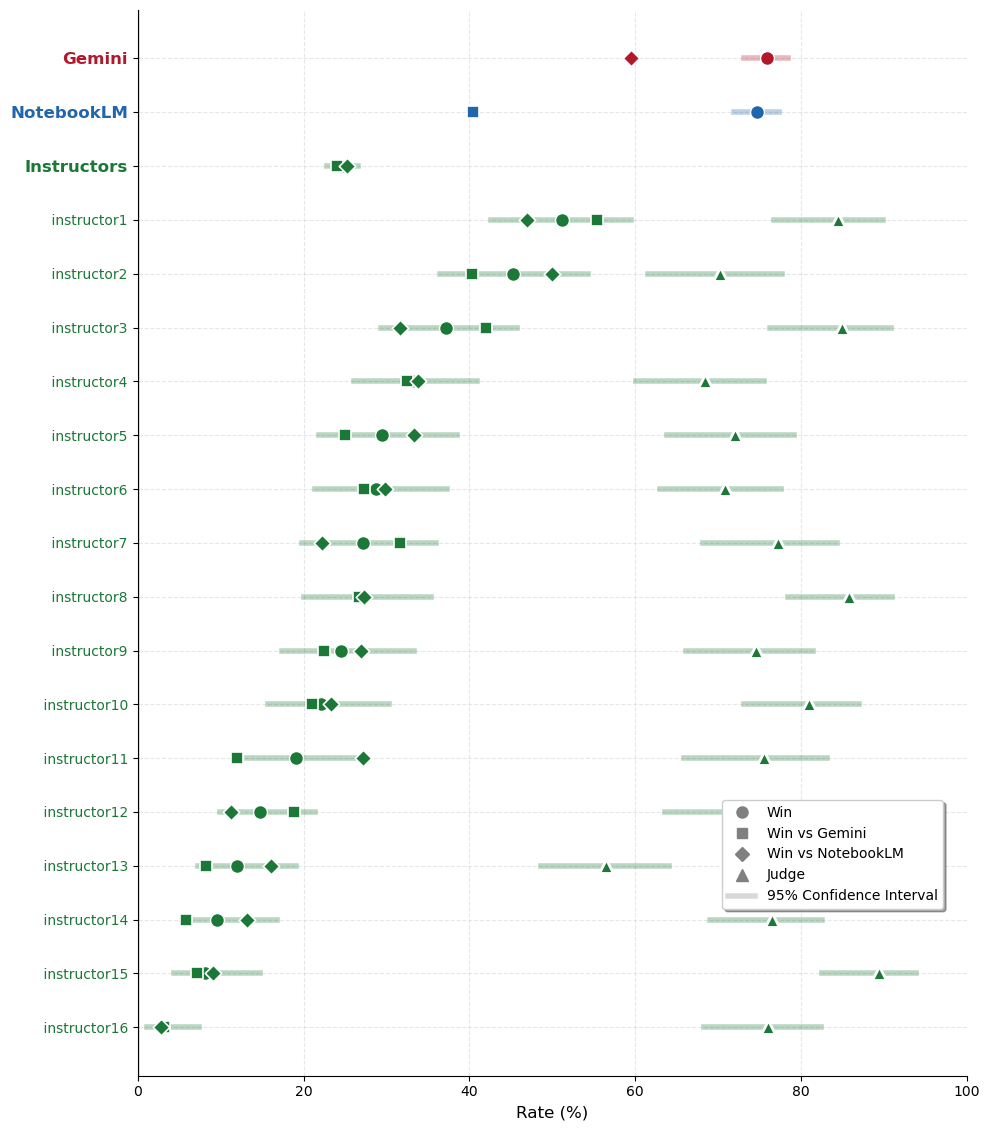

In [17]:
# Generate and display Figure 2
fig, ax = create_win_rate_plot(df_wins, show_individual_ci=True, show_judge_ci=True, save_path="figures/win_rates.png")

# Save high-resolution version for the paper
from pathlib import Path
Path("figures").mkdir(exist_ok=True)
fig.savefig("figures/win_rates.png", dpi=300, bbox_inches="tight")

plt.show()